In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from drawarrow import ax_arrow, fig_arrow
from matplotlib.font_manager import FontProperties
from highlight_text import fig_text, ax_text
from pyfonts import load_font

In [2]:
water_quality = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-05-20/water_quality.csv")
weather = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-05-20/weather.csv")

In [3]:
water_quality["date"] = pd.to_datetime(water_quality["date"])
weather["date"] = pd.to_datetime(weather["date"])

In [4]:
water_quality["year"] = water_quality["date"].dt.year
weather["year"] = weather["date"].dt.year

In [5]:
# Remove year 2025
water_quality = water_quality[water_quality["year"] != 2025]  

In [6]:
water_quality.head(3)

,region,council,swim_site,date,time,enterococci_cfu_100ml,water_temperature_c,conductivity_ms_cm,latitude,longitude,year
1288,Northern Sydney,Northern Beaches Council,Warriewood Beach,2024-12-31,09:00:00,0.0,NaN,NaN,-33.691070,151.309221,2024
1289,Northern Sydney,Northern Beaches Council,Narrabeen Lagoon (Birdwood Park),2024-12-31,08:43:00,21.0,24.0,54200.0,-33.703993,151.304952,2024
1290,Northern Sydney,Northern Beaches Council,Dee Why Beach,2024-12-31,07:58:00,1.0,22.0,54500.0,-33.753299,151.297338,2024


In [7]:
water_quality = water_quality.groupby("year")["enterococci_cfu_100ml"].mean().reset_index()

In [8]:
water_quality["cat"] = pd.cut(water_quality["enterococci_cfu_100ml"],
                              [0, 41, 201, 501, np.inf],
                              labels=["low","medium","high","very high"],
                              right=False # to include 0.0 values
                              )

In [9]:
water_quality.head(3)

,year,enterococci_cfu_100ml,cat
0,1991,0.000000,low
1,1992,0.000000,low
2,1993,49.705486,medium


In [10]:
weather.head(3)

,date,max_temp_C,min_temp_C,precipitation_mm,latitude,longitude,year
0,1991-01-01,29.3,22.1,2.4,-33.848858,151.19551,1991
1,1991-01-02,27.5,22.4,0.0,-33.848858,151.19551,1991
2,1991-01-03,28.2,21.1,0.0,-33.848858,151.19551,1991


In [11]:
# Remove year 2025
weather = weather[weather["year"] != 2025]  

In [12]:
weather.head(3)

,date,max_temp_C,min_temp_C,precipitation_mm,latitude,longitude,year
0,1991-01-01,29.3,22.1,2.4,-33.848858,151.19551,1991
1,1991-01-02,27.5,22.4,0.0,-33.848858,151.19551,1991
2,1991-01-03,28.2,21.1,0.0,-33.848858,151.19551,1991


In [13]:
total_precipitation = weather["precipitation_mm"].sum()

In [14]:
weather["daily_avg_temp"] = (weather["max_temp_C"] + weather["min_temp_C"])/2
total_avg_temp = weather["daily_avg_temp"].mean()

In [15]:
df1 = weather.groupby("year").agg(
    sum_precipitation=pd.NamedAgg(column="precipitation_mm", aggfunc="sum"),
    avg_temp=pd.NamedAgg(column="daily_avg_temp", aggfunc="mean")
).reset_index()

In [16]:
df = pd.merge(water_quality, df1, on="year")

In [17]:
avg_precipitation = df["sum_precipitation"].mean()

In [18]:
df["avg_precipitation"] = avg_precipitation
df["total_avg_tem"] = total_avg_temp

In [19]:
df["percent_precipitation"] = round((df["sum_precipitation"] / df["avg_precipitation"])*100).astype(int)

In [20]:
df["temp_diff"] = df["avg_temp"] - df["total_avg_tem"]

In [21]:
df.head(3)

,year,enterococci_cfu_100ml,cat,sum_precipitation,avg_temp,avg_precipitation,total_avg_tem,percent_precipitation,temp_diff
0,1991,0.000000,low,632.9,17.737671,738.032353,17.718077,86,0.019594
1,1992,0.000000,low,788.7,16.805055,738.032353,17.718077,107,-0.913022
2,1993,49.705486,medium,524.4,17.446301,738.032353,17.718077,71,-0.271776


In [22]:
color_mapping = {
    "low":"#1BA3C6",
    "medium":"#78AB30",
    "high":"#F8B11F",
    "very high":"#E23B25"    
}
colors = df["cat"].map(color_mapping)

In [23]:
font_path = 'Futura Bold.otf'
futura = FontProperties(fname=font_path)

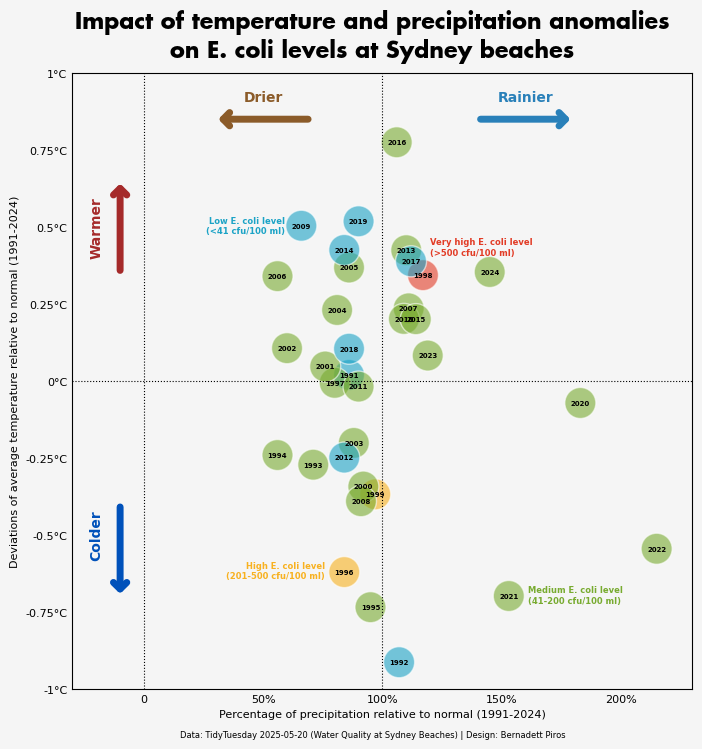

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(df["percent_precipitation"], df["temp_diff"], c=colors, s=500, alpha=0.6, ec="white", lw=1)

for i, row in df.iterrows():
    year = row["year"]
    x_value = row["percent_precipitation"]
    y_value = row["temp_diff"]
    ax.text(
        x=x_value,
        y=y_value,
        s=year,
        ha="center",
        va="center",
        color="black",
        size=5,
        weight="bold"
    )

ax.set_xlim(-30, 230)
ax.set_ylim(-1, 1)

ax.set_xlabel("Percentage of precipitation relative to normal (1991-2024)", loc="center", fontsize=8)
ax.set_ylabel("Deviations of average temperature relative to normal (1991-2024)", loc="center", fontsize=8)

ax.text(59, 0.48, "Low E. coli level\n(<41 cfu/100 ml)", color=color_mapping['low'], size=6, weight="bold", ha="right")
ax.text(161, -0.72, "Medium E. coli level\n(41-200 cfu/100 ml)", color=color_mapping['medium'], size=6, weight="bold")
ax.text(76, -0.64, "High E. coli level\n(201-500 cfu/100 ml)", color=color_mapping['high'], size=6, weight="bold", ha="right")
ax.text(120, 0.41, "Very high E. coli level\n(>500 cfu/100 ml)", color=color_mapping['very high'], size=6, weight="bold")

location = [0, 50, 100, 150, 200]
labels = ["0","50%", "100%", "150%", "200%"]
ax.set_xticks(location, labels=labels)

location = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]
labels = ["-1\u00b0C", "-0.75\u00b0C", "-0.5\u00b0C", "-0.25\u00b0C", "0\u00b0C", "0.25\u00b0C", "0.5\u00b0C", "0.75\u00b0C", "1\u00b0C"]
ax.set_yticks(location, labels=labels)

ax.tick_params(length=0)
ax.tick_params(
    axis="both",
    labelsize=8,    
)

ax.axvline(color='black', lw=0.8, ls='dotted')
ax.axhline(color='black', lw=0.8, ls='dotted')
ax.axvline(x=100, color='black', lw=0.8, ls='dotted')

ax.text(-20, 0.50, "Warmer", rotation=90, ha='center', va='center', color="#A52A2A", weight="bold", size=10)
ax.text(-20, -0.50, "Colder", rotation=90, ha='center', va='center', color="#0051BA", weight="bold", size=10)
ax.text(50, 0.92, "Drier", ha='center', va='center', color="#8B5B29", weight="bold", size=10)
ax.text(160, 0.92, "Rainier", ha='center', va='center', color="#2980B9", weight="bold", size=10)

ax_arrow(
   tail_position=[-10, 0.35],
   head_position=[-10, 0.65],
   color="#A52A2A",
   fill_head=False,
   width=5,
   head_width=4.8,
   head_length=4.7   
)

ax_arrow(
   tail_position=[-10, -0.4],
   head_position=[-10, -0.7],
   color="#0051BA",
   fill_head=False,
   width=5,
   head_width=4.8,
   head_length=4.7   
)

ax_arrow(
   tail_position=[70, 0.85],
   head_position=[30, 0.85],
   color="#8B5B29",
   fill_head=False,
   width=5,
   head_width=4.8,
   head_length=4.7   
)

ax_arrow(
   tail_position=[140, 0.85],
   head_position=[180, 0.85],
   color="#2980B9",
   fill_head=False,
   width=5,
   head_width=4.8,
   head_length=4.7   
)

fig.text(0.5, 0.9, "Impact of temperature and precipitation anomalies\non E. coli levels at Sydney beaches",
         size=16, ha="center", font=futura)

fig.text(0.5, 0.05, "Data: TidyTuesday 2025-05-20 (Water Quality at Sydney Beaches) | Design: Bernadett Piros",
         size=6, ha="center")

ax.set_facecolor("#F5F5F5")
fig.set_facecolor("#F5F5F5")

plt.show()

#fig.savefig("2025-05-20.1.png", bbox_inches='tight', pad_inches=0.2)

# Second chart

In [25]:
water_quality = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-05-20/water_quality.csv")
weather = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-05-20/weather.csv")

In [26]:
water_quality["date"] = pd.to_datetime(water_quality["date"])
water_quality["year"] = water_quality["date"].dt.year
water_quality["month"] = water_quality["date"].dt.month

In [27]:
water_quality["cat"] = pd.cut(water_quality["enterococci_cfu_100ml"],
                              [0, 41, 201, 501, np.inf],
                              labels=["low","medium","high","very high"],
                              right=False # to include 0.0 values
                              )

In [28]:
sydney_harbour = water_quality[water_quality["region"] == "Sydney Harbour"]

In [29]:
df = sydney_harbour.groupby(["year"])["cat"].value_counts(normalize=True, dropna=False).reset_index()

In [30]:
weather["date"] = pd.to_datetime(weather["date"])
weather["year"] = weather["date"].dt.year

In [31]:
by_year = weather.groupby("year")["precipitation_mm"].sum().reset_index()

In [32]:
color_mapping = {
    "low": "#005F7F",
    "medium": "#00A3E0",
    "high": "#FFC107",
    "very high": "#FF6F20",
    np.nan: "grey"
}
colors = df["cat"].map(color_mapping)

In [33]:
nosifer = load_font(
  font_url="https://github.com/google/fonts/blob/main/ofl/nosifer/Nosifer-Regular.ttf?raw=true"
)

In [34]:
years = df["year"].unique()

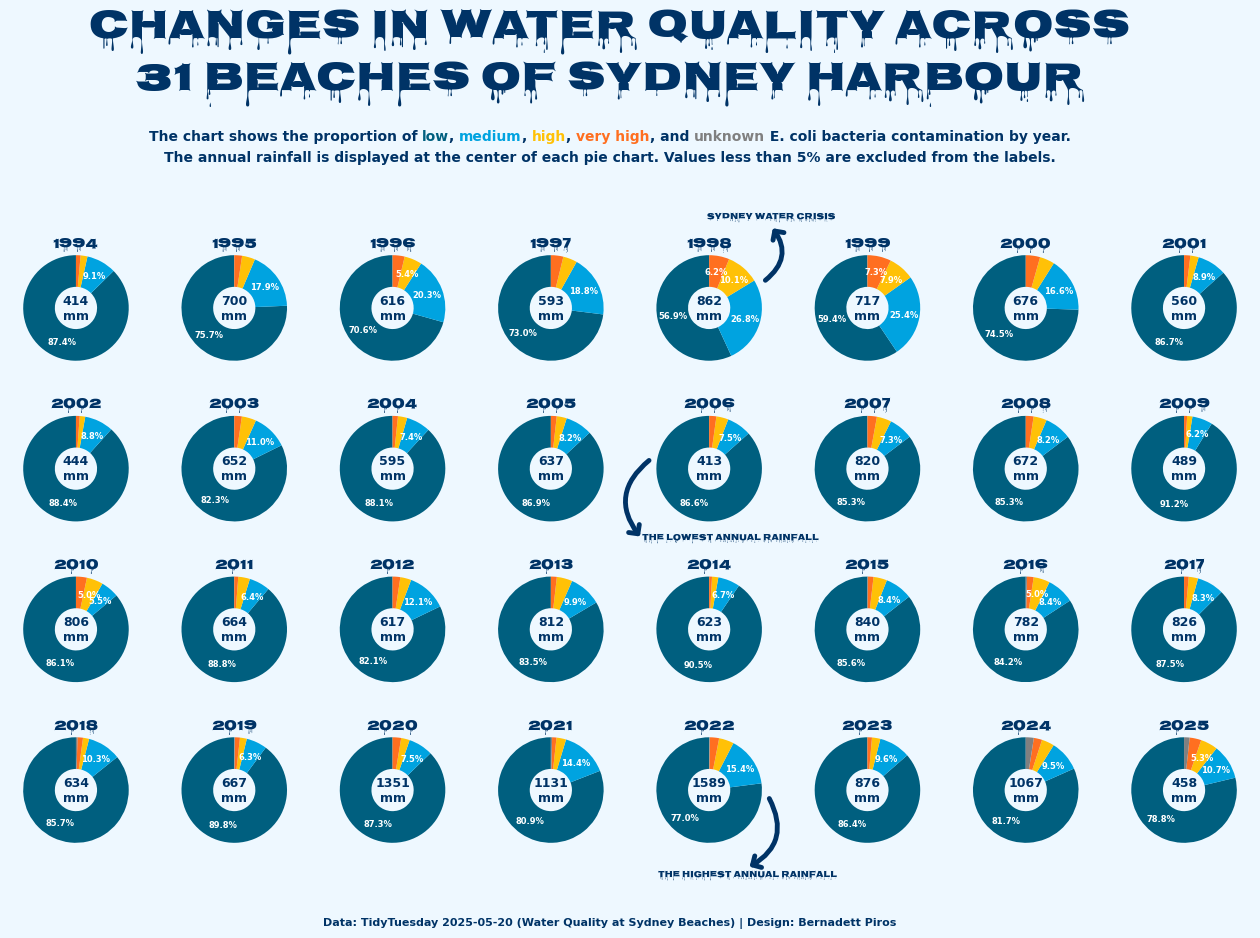

In [35]:
fig, axs = plt.subplots(4, 8, figsize=(16, 8))

year_idx = 0
for i, ax in enumerate(axs.flat):
    year = years[year_idx]
    year_idx += 1

    year_data = df[df["year"] == year]
    categories = year_data["cat"]
    values = year_data["proportion"]  

    wedges, texts, autotexts = ax.pie(
        values,
        labels=None,
        colors=colors,
        autopct="%1.1f%%",
        pctdistance=0.7,
        startangle=90,        
        wedgeprops={"width": 0.6},
        textprops={"fontsize":6, "weight":"bold"}
    )

    # Add text to the center of the pie chart
    rain_value = by_year[by_year['year'] == year]['precipitation_mm'].values[0]
    ax.text(0, 0, f'{rain_value:.0f}\nmm', ha='center', va='center', fontsize=9, color='#003366', weight="bold")

    # Set labels and labelcolor
    for wedge, label, value, autotext in zip(wedges, categories, values, autotexts):
        if value < 0.05:
            autotext.set_text("")  
        else:
            autotext.set_color("white")  

    ax.set_title(f"{year}", y=0.9, fontsize=20, color="#003366", font=nosifer)
    
# 1998
bbox = axs[0, 4].get_position()
x0, y0 = bbox.x0, bbox.y0
x1, y1 = bbox.x1, bbox.y1

tail_position = [x0 + 0.075, y1 - 0.05]
head_position = [x0 + 0.08,  y1 + 0.02]

fig_arrow(
   tail_position=tail_position,
   head_position=head_position,
   color="#003366",
   fill_head=False,
   width=3.5,
   head_width=4.8,
   head_length=4.7,
   radius=0.5,
)

fig.text(head_position[0],
        head_position[1] + 0.01,
        s="Sydney Water Crisis",
        font=nosifer,
        fontsize=6,
        color="#003366",
        ha="center"
        )

# 2006
bbox = axs[1, 4].get_position()
x0, y0 = bbox.x0, bbox.y0
x1, y1 = bbox.x1, bbox.y1

tail_position = [x0 + 0.005,  y1 - 0.07]
head_position = [x0 - 0.001,  y1 - 0.17]

fig_arrow(
   tail_position=tail_position,
   head_position=head_position,
   color="#003366",
   fill_head=False,
   width=3.5,
   head_width=4.8,
   head_length=4.7,
   radius=0.5,
)

fig.text(head_position[0],
         head_position[1],
         s="The lowest annual rainfall",
         font=nosifer,
         fontsize=6,
         color="#003366"
         )   

# 2022
bbox = axs[3, 4].get_position()
x0, y0 = bbox.x0, bbox.y0       
x1, y1 = bbox.x1, bbox.y1       

tail_position = [x0 + 0.078, y1 - 0.09]
head_position = [x0 + 0.065,  y1 - 0.18]

fig_arrow(
   tail_position=tail_position,
   head_position=head_position,
   color="#003366",
   fill_head=False,
   width=3.5,
   head_width=4.8,
   head_length=4.7,
   radius=-0.5   
)

fig.text(head_position[0],
         head_position[1] - 0.01,
         s="The highest annual rainfall",
         font=nosifer,
         fontsize=6,
         color="#003366",
         ha="center"
         )         

fig.set_facecolor("#eef8ff")

fig.text(0.5, 1.07, "Changes in Water Quality Across\n31 Beaches of Sydney Harbour",
         color="#003366", size=30, font=nosifer, ha="center")

fig_text(0.5, 1.02, s="The chart shows the proportion of <low>, <medium>, <high>, <very high>, and <unknown> E. coli bacteria contamination by year.",
         color="#003366", weight="bold", size=10, ha="center",
         highlight_textprops=[
             {"color": color_mapping["low"]},
             {"color": color_mapping["medium"]},
             {"color": color_mapping["high"]},
             {"color": color_mapping["very high"]},
             {"color": color_mapping[np.nan]},
             ])       

fig.text(0.5, 0.98, s="The annual rainfall is displayed at the center of each pie chart. Values less than 5% are excluded from the labels.",
         color="#003366", weight="bold", size=10, ha="center")

fig.text(0.5, 0.025, "Data: TidyTuesday 2025-05-20 (Water Quality at Sydney Beaches) | Design: Bernadett Piros",
         color="#003366", size=8, weight="bold", ha="center")

plt.show()

#fig.savefig("2025-05-20.2.png", bbox_inches='tight', pad_inches=0.2)